###                        Modelling Using 4 Different Types of Classification Algorithms

In [2]:
#import the required libraries
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, preprocessing
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

In [3]:
#import data
stroke_data = pd.read_csv('../data/stroke_data_explored.csv')

In [13]:
#Checking the number of rows and columns
stroke_data.shape
stroke_data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,67.0,0,1,228.69,36.6,0,1,0,1,0,...,1,0,0,0,1,0,1,0,0,1
1,61.0,0,0,202.21,28.9,1,0,0,1,0,...,0,1,0,1,0,0,0,1,0,1
2,80.0,0,1,105.92,32.5,0,1,0,1,0,...,1,0,0,1,0,0,0,1,0,1
3,49.0,0,0,171.23,34.4,1,0,0,1,0,...,1,0,0,0,1,0,0,0,1,1
4,79.0,1,0,174.12,24.0,1,0,0,1,0,...,0,1,0,1,0,0,0,1,0,1


In [5]:
# Convert categorical data into dummy features
stroke_data = pd.get_dummies(stroke_data)
# Reordering the DataFrameccolumns
reorder = list(stroke_data.columns)
reorder.remove('stroke')
reorder.append('stroke')
stroke_data = stroke_data[reorder]
stroke_data['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [7]:
# Checking for class imbalance
stroke_data['stroke'][stroke_data['stroke']==0].count()

4860

In [8]:
# Imbalance handling using up-resampling 
from sklearn.utils import resample

without_stroke = stroke_data[stroke_data.stroke == 0]
with_stroke = stroke_data[stroke_data.stroke == 1]

with_stroke_upsampled = resample(with_stroke,
                       replace=True,
                       n_samples=4860,
                       random_state=0)

stroke_data_upsampled = pd.concat([without_stroke,with_stroke_upsampled])

stroke_data_upsampled.stroke.value_counts()

1    4860
0    4860
Name: stroke, dtype: int64

In [17]:
#Splitting data into dependent and independent features
y = stroke_data_upsampled['stroke']
X = stroke_data_upsampled.drop('stroke', axis=1)
#y = stroke_data['stroke']
#X = stroke_data.drop('stroke', axis=1)

In [18]:
#Splitting the data into train set and test set 
import sklearn.model_selection #as train_test_split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7776, 20) (1944, 20) (7776,) (1944,)


In [19]:
#Using Standard Scaler to scale the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
#scaler.fit(X_train[['age','avg_glucose_level','bmi']])
X_train_scaled = scaler.fit_transform(X_train[['age','avg_glucose_level','bmi']])
X_test_scaled = scaler.transform(X_test[['age','avg_glucose_level','bmi']])

### Model1:
### KNeighborsClassifier using Grid Search CV for Hyperparameter optimization

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors':np.arange(1,10)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train_scaled,y_train)
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))
print(knn_cv.cv_results_)

Best Score:0.9668208532059281
Best Parameters: {'n_neighbors': 1}
{'mean_fit_time': array([0.00355797, 0.00224996, 0.00231061, 0.0024014 , 0.00232344,
       0.00226769, 0.00227704, 0.00228906, 0.00228066]), 'std_fit_time': array([1.27623507e-03, 2.98017502e-05, 8.11544904e-05, 1.54150870e-04,
       1.02814363e-04, 3.71573960e-05, 4.86875257e-05, 3.16380646e-05,
       3.78800231e-05]), 'mean_score_time': array([0.03165846, 0.04156456, 0.02612357, 0.02681227, 0.02733274,
       0.02682557, 0.02830901, 0.02771602, 0.02756119]), 'std_score_time': array([0.00783293, 0.0308036 , 0.00039311, 0.0006571 , 0.00041747,
       0.00022561, 0.00101486, 0.00028471, 0.00034885]), 'param_n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 1}, {'n_neighbors': 2}, {'n_neighbors': 3}, {'n_neighbors': 4}, {'n_neighbors

Testing Score :  0.9002057613168725
Confusion Matrix


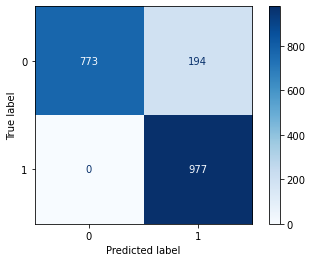

 0 - No Risk Of Stroke(Positive)  
 1 - High Risk Of Stroke(Negative)

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       967
           1       0.83      1.00      0.91       977

    accuracy                           0.90      1944
   macro avg       0.92      0.90      0.90      1944
weighted avg       0.92      0.90      0.90      1944



In [23]:
model1 = KNeighborsClassifier(n_neighbors=8)
model1.fit(X_train_scaled,y_train)
y_pred1 = model1.predict(X_test_scaled)

score1 = model1.score(X_test_scaled, y_test)
print('Testing Score : ',score1)
print('Confusion Matrix')
plot_confusion_matrix(model1,X_test_scaled,y_test,cmap="Blues")
plt.show()

print(' 0 - No Risk Of Stroke(Positive)  \n 1 - High Risk Of Stroke(Negative)\n')

print('Classification Report')
print(classification_report(y_test,y_pred1))


#### Observation1 :
The best parameter obtained by implementing GridSearchCV is n_neighbors = 8.
Training the KNeighborsClassifier model on the data yielded a test score of 90%.

Out of 967 actual positive(no risk) values: 
The model made 773 correct positive(No Risk of Stroke) predictions.
194 were inacuurately predicted as negative(High Risk Of stroke)

Out of 977 actual negative(high risk) values: 
The model made 977 correct negative(high Risk of Stroke) predictions with no inaccurate predictions for (No risk of stroke)

With a recall value of 100% the model is sensitive to negative predictions.

### Model2:
### Decision Tree


 The test score for DecisionTree is : 0.970679012345679


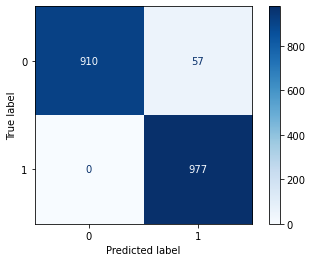

 0 - No Risk Of Stroke(Positive)  
 1 - High Risk Of Stroke(Negative)

Classification Report For DecisionTree
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       967
           1       0.94      1.00      0.97       977

    accuracy                           0.97      1944
   macro avg       0.97      0.97      0.97      1944
weighted avg       0.97      0.97      0.97      1944



In [25]:
#Implementing Decision Tree

#import required library
from sklearn.tree import DecisionTreeClassifier

model2 = DecisionTreeClassifier(random_state = 42)
model2.fit(X_train_scaled,y_train)
y_pred2 = model2.predict(X_test_scaled)
score2 = model2.score(X_test_scaled, y_test)
print('\n The test score for DecisionTree is :',score2)
plot_confusion_matrix(model2,X_test_scaled,y_test,cmap="Blues")
plt.show()

print(' 0 - No Risk Of Stroke(Positive)  \n 1 - High Risk Of Stroke(Negative)\n')

print('Classification Report For DecisionTree')
print(classification_report(y_test,y_pred2))

#### Observation 2:

Out of 967 actual positive(no risk) values: 
The model made 910 correct positive(No Risk of Stroke) predictions.
57 were inacuurately predicted as negative(High Risk Of stroke)

Out of 977 actual negative(high risk) values: 
The model made 977 correct negative(high Risk of Stroke) predictions with no inaccurate predictions for (No risk of stroke)

Overall, the model2 has 97% accuracy and it has performed bettter than model1.

### Model3:
### RandomForestClassifier  using RandomSearchCV for Hyperparameter optimization

In [28]:
#Implementing RandomSearchCV for Hyperparameter optimization and selection 

#import required library
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV

rfc = RandomForestClassifier()

#Number of trees
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
#Number of features to consider in every split
max_features = ['auto', 'sqrt']
#Max number of levels
max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=11)]
max_depth.append(None)
#Max number of samples needed to split at a node
min_samples_split = [2,5,10]
#Min number of samples needed ato split at a node
min_samples_leaf = [1,2,4]
#Method of selecting sample to train each tree
bootstrap = [True, False]

#Creating random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 
               'min_samples_leaf': min_samples_leaf, 
               }

#Random Search using 3 fold cross validation and random grid
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

#Fit the model
rf_random.fit(X_train_scaled,y_train)



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.3s
/Users/pranoti/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 19, 28, 37, 46, 55,
                                                      64, 73, 82, 91, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [29]:
print(rf_random.best_score_)
print(rf_random.best_estimator_)

0.976466049382716
RandomForestClassifier(max_depth=91, max_features='sqrt', n_estimators=1400)


Confusion Matrix

 Test score for RandomForestClassifier is :  0.9567901234567902


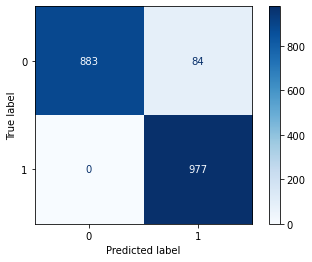

 0 - No Risk Of Stroke(Positive)  
 1 - High Risk Of Stroke(Negative)

Classification Report For RandomForestClassifier:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       967
           1       0.92      1.00      0.96       977

    accuracy                           0.96      1944
   macro avg       0.96      0.96      0.96      1944
weighted avg       0.96      0.96      0.96      1944



In [30]:
#Creating the RandomForestClassifier model using the best parameters from RandomSearchCV
model3 = RandomForestClassifier(max_depth=46, min_samples_leaf=4, n_estimators=1800, random_state=24)#(n_estimators=800, criterion='gini', max_depth = None, max_features='sqrt', min_samples_leaf=1,min_samples_split=2)
model3.fit(X_train_scaled,y_train)

#Model prediction on test set
y_pred3 = model3.predict(X_test_scaled)
print('Confusion Matrix')

score3 = model3.score(X_test_scaled, y_test)
print('\n Test score for RandomForestClassifier is : ', score3)
plot_confusion_matrix(model3,X_test_scaled,y_test,cmap="Blues")
plt.show()

print(' 0 - No Risk Of Stroke(Positive)  \n 1 - High Risk Of Stroke(Negative)\n')

print('Classification Report For RandomForestClassifier:')
print(classification_report(y_test,y_pred3))


####  Observation 3:

Best parameters obtained by implementing RandomSearchCV are max_depth=46, min_samples_leaf=4, n_estimators=1800.

Using these parameters the trained model gave following output:

Out of 967 actual positive(no risk) values: 
The model made 883 correct positive(No Risk of Stroke) predictions.
84 were inacuurately predicted as negative(High Risk Of stroke)

Out of 977 actual negative(high risk) values: 
The model made 977 correct negative(high Risk of Stroke) predictions with no inaccurate predictions for (No risk of stroke)

Overall, the model3 has 95% accuracy and it has better accuracy score compared to model1(KNeighborClassification) but lower as compared to model2(DecisionTree).

### Model4:
### LogisticRegression


 Testing Score for LogisticRegression is :  0.7705761316872428


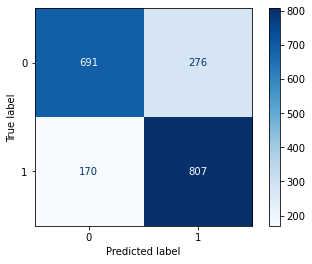

 0 - No Risk Of Stroke(Positive)  
 1 - High Risk Of Stroke(Negative)

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.80      0.71      0.76       967
           1       0.75      0.83      0.78       977

    accuracy                           0.77      1944
   macro avg       0.77      0.77      0.77      1944
weighted avg       0.77      0.77      0.77      1944



In [31]:
from sklearn.linear_model import LogisticRegression

model4 = LogisticRegression(random_state=42)
model4.fit(X_train_scaled,y_train)
y_pred4 = model4.predict(X_test_scaled)

score4 = model4.score(X_test_scaled, y_test)
print('\n Testing Score for LogisticRegression is : ',score4)
plot_confusion_matrix(model4,X_test_scaled,y_test,cmap="Blues")
plt.show()

print(' 0 - No Risk Of Stroke(Positive)  \n 1 - High Risk Of Stroke(Negative)\n')

print('Classification Report for LogisticRegression:')
print(classification_report(y_test,y_pred4))

#### Observation 4:

Out of 967 actual positive(no risk) values: 
The model made 691 correct positive(No Risk of Stroke) predictions. 
276 were inacuurately predicted as negative(High Risk Of stroke)

Out of 977 actual negative(high risk) values:
The model made 807 correct negative(high Risk of Stroke) predictions. 
170 were inacuurately predicted as negative(Low Risk Of stroke)

Overall, the model3 has 77% accuracy and it is the worst performing model amongst all.

### Summary:

The stroke data was analyzed and processed for machine learning model implementation to predict stroke based on history of medical conditions and lifestyle features.
Predicition of stroke is a classification problem, four different types of classification machine learning algorithms were implemented and performance of different models were evaluated to find the best model to predict the stroke. 
The models were compared and eveluated using the confusion Matrix and classification report.


### Conclusion:

Out of all of the applied models on stroke data to predict the possiblity of a person being at high risk of getting stroke, RandomForest with an overall prediction accuracy of 95% is the best model. The model is balanced and is likely to make accurate predictions for positive values (people with a low risk of getting a stroke) and not identifying 'people with high risk' falsely to not be at risk of getting a stroke. The model is sensitive to negative values for the problem at hand; having a false negative is a superior alternative to having a false positive.